# Car dataset classification
Ivan Kakhaev 0860838   
This file origin [github.](https://github.com/veax-void/stanford_car_classification/blob/main/main.ipynb)
## 0. Setup
First of all load necessary libs and set all necessary hyperparameters.


In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

from efficientnet_pytorch import EfficientNet

from fastprogress.fastprogress import master_bar, progress_bar


In [2]:
'''Hyperparameters'''
# Seed for random setup
seed = 69

# Model training parameters
image_size = (244, 244)
batch_size = 44
k_folds = 5
n_epochs = 40

MODEL_NAME = 'efficientnet-b2'

# learning rate for SGD and max_lr for OneCycle scheduler
lr = 0.001
max_lr = 0.1

# Number of Test Time Augmentations, must be even
# because we have one unaugmented prediction.
n_TTA = 8

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


## 1. Data preparing
I load the data and check that my labels and images in right order.

In [3]:
train_path = 'cars/training_data'
test_path = 'cars/testing_data'

train_file_paths = [os.path.join(train_path, fn) for fn in sorted(os.listdir(train_path))]
test_file_paths = [os.path.join(test_path, fn) for fn in os.listdir(test_path)]  # sorted

train_labels = pd.read_csv('cars/training_labels.csv')
train_labels.sort_values('id', inplace=True)

train_labels['label'] = train_labels['label'].astype('category')

# Check
print(train_file_paths[:4])
train_labels


['cars/training_data/000001.jpg', 'cars/training_data/000002.jpg', 'cars/training_data/000003.jpg', 'cars/training_data/000007.jpg']


,id,label
69,1,AM General Hummer SUV 2000
3128,2,AM General Hummer SUV 2000
10629,3,AM General Hummer SUV 2000
5949,7,AM General Hummer SUV 2000
7595,9,AM General Hummer SUV 2000
...,...,...
1454,16179,smart fortwo Convertible 2012
1897,16182,smart fortwo Convertible 2012
4376,16183,smart fortwo Convertible 2012
4616,16184,smart fortwo Convertible 2012


Here is the categorical classes encoding to int values. 

In [17]:
# Numerical encoding of train labels
classes = train_labels['label'].cat.categories
# classes = train_labels['label'].unique().copy()
train_targets = train_labels['label'].cat.codes.values.astype(np.long)
print(classes[:4])
train_targets


Index(['AM General Hummer SUV 2000', 'Acura Integra Type R 2001',
       'Acura RL Sedan 2012', 'Acura TL Sedan 2012'],
      dtype='object')


array([  0,   0,   0, ..., 195, 195, 195])

# Data preparing 
I made custum Dataset for cars, that handle train and test case.

In [5]:
class DatasetCars(Dataset):
    def __init__(self, file_paths, labels=None, transforms=None):
        self.file_paths = file_paths
        self.transforms = transforms
        self.labels = labels

    def __getitem__(self, idx):
        img = Image.open(self.file_paths[idx]).convert('RGB')

        if self.transforms:
            img = self.transforms(img)

        # TRAIN MODE
        if self.labels is not None:
            target = self.labels[idx]

            return img, target

        # TEST MODE
        return img

    def __len__(self):
        return len(self.file_paths)


This is the function that returns train and validation dataloaders based on passed filepath and encoded targets.

In [6]:
def get_loaders(train_fp, val_fp, train_y, val_y, transform, workers=8):
    train_set = DatasetCars(train_fp, train_y, transform)
    valid_set = DatasetCars(val_fp, val_y, transform)

    train_loader = DataLoader(dataset=train_set, batch_size=batch_size,
                              shuffle=True, num_workers=workers)
    val_loader = DataLoader(dataset=valid_set, batch_size=batch_size,
                            shuffle=True, num_workers=workers)
    return train_loader, val_loader

Here I defined mean and std for normalization, it just default values.  
And then couple of transformations for train data and transformation only with resizing for test data.
I iresize image by (244,244) then with probability 0.5 can flip it horizontaly. Than apply with random order: Affine transform, random rotation, color jitter, and randomly with probability 0.5 apply resized crop. After translating in to the tensors, randomly errase part of the image with zeros or randon noize. At the end normilize it. 

In [7]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = transforms.Compose(
    [transforms.Resize(image_size),
     transforms.RandomHorizontalFlip(),
     transforms.RandomOrder([
         transforms.RandomAffine(14),
         transforms.RandomRotation(20),
         transforms.ColorJitter(0.10, 0.10, 0.10, 0.10),
         transforms.RandomApply([
             transforms.RandomResizedCrop(244, scale=(.5, 1.0))
         ])
     ]),
     transforms.ToTensor(),
     transforms.RandomChoice([
         transforms.RandomErasing(p=.5),
         transforms.RandomErasing(p=.5, value='random')
     ]),
     transforms.Normalize(mean, std)])

test_transform = transforms.Compose([transforms.Resize(image_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std)])


Here we can check how our train data look after transformation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


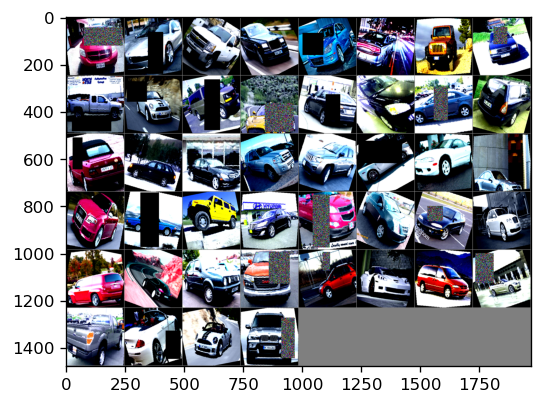

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision


def imshow(img):
    # functions to show an image
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(5, 15), dpi=120)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
trainloader, _ = get_loaders(train_file_paths, train_targets,
                             train_file_paths, train_targets, transform)
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))


# Model
I choose to train models from EfficientNet family, thay perform really well and easy to scale. Here I defined function for getting one EfficientNet model with MODEL_NAME (MODEL_NAME is hyperparameter), and *n_classes* indecate number of outputs in new head. Also you could set transfer learning mode set *is_transfer* flag to True.

In [9]:
def get_model(n_classes, is_transfer=False):
    model = EfficientNet.from_pretrained(MODEL_NAME)
    # Transfer learning
    if is_transfer:
        for param in model.parameters():
            param.requires_grad = False

    model._fc = torch.nn.Linear(model._fc.in_features, n_classes)
    return model


# Training
I use K-Fold cross validation for training strategy, for each K-Fold I will train new model and save it for leter predictions. For loss function I of course used **Cross Entropy** and for optimizer used **SGD** with **OneCycleLR** scheduler.

In [11]:
from sklearn.model_selection import KFold

#
# Setup K-FOLDS
X = np.array(train_file_paths)
y = np.array(train_targets)

kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

for fold_num, (train_idx, val_idx) in enumerate(kf.split(train_file_paths)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    #
    # Get dataloaders for this fold
    train_loader, val_loader = get_loaders(X_train, X_val,
                                           y_train, y_val, transform)

    #
    # Setup the model for this fold
    n_classes = np.unique(train_targets).size
    model = get_model(n_classes)
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=len(train_loader),
        epochs=n_epochs)

    #
    # Train & evaluate model
    mb = master_bar(range(n_epochs))
    mb.write(['epoch', 'train_loss', 'valid_loss', 'val_acc'], table=True)

    for epoch in mb:  # loop over the dataset multiple times
        # Training
        model.train()
        training_loss = []

        for inputs, labels in progress_bar(train_loader, parent=mb):
            # get the inputs; data is a list of [inputs, labels]
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            training_loss += [loss.item()]

        # Validation
        model.eval()
        val_loss = []
        val_acc = []

        with torch.no_grad():
            for inputs, labels in progress_bar(val_loader, parent=mb):
                # get the inputs; data is a list of [inputs, labels]
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)

                _, predicted = torch.max(outputs.data, 1)
                val_acc += (predicted == labels).tolist()
                val_loss += [criterion(outputs, labels).item()]

        # Report
        mb.write([epoch+1,
                  f'{np.mean(training_loss):.6f}',
                  f'{np.mean(val_loss):.6f}',
                  f'{np.sum(val_acc)/len(val_acc):.6f}'], table=True)
    #
    # Save the model
    PATH = f'./models/{MODEL_NAME}_fold_{fold_num}.pth'
    torch.save(model.state_dict(), PATH)

print('Training finished.')


Loaded pretrained weights for efficientnet-b2


epoch,train_loss,valid_loss,val_acc
1,5.173312,4.820636,0.069736
2,3.953559,2.852510,0.303084
3,2.240035,2.277653,0.408583
4,1.627247,2.481066,0.385785
5,1.468868,2.579230,0.402325
6,1.345839,1.991835,0.492624
7,1.167865,1.764375,0.557443
8,1.008631,2.863801,0.373715
9,0.894050,2.352020,0.472508
10,0.822944,1.831871,0.557443


Loaded pretrained weights for efficientnet-b2


epoch,train_loss,valid_loss,val_acc
1,5.171954,4.851874,0.062137
2,3.991248,2.933627,0.301296
3,2.243888,2.378417,0.417076
4,1.621088,2.161355,0.439875
5,1.427442,2.020902,0.498882
6,1.254900,2.392860,0.430040
7,1.178684,2.459460,0.428252
8,1.046943,1.849591,0.530621
9,0.927362,1.993501,0.531962
10,0.835398,1.703775,0.588735


Loaded pretrained weights for efficientnet-b2


epoch,train_loss,valid_loss,val_acc
1,5.171205,4.810514,0.061243
2,3.973285,3.053068,0.272240
3,2.238756,2.443400,0.383996
4,1.646654,2.225077,0.431381
5,1.450627,2.359154,0.426017
6,1.288177,2.481086,0.398748
7,1.181977,2.158382,0.460885
8,1.039651,2.129207,0.480554
9,0.932200,1.703717,0.576218
10,0.824734,1.819346,0.551632


Loaded pretrained weights for efficientnet-b2


epoch,train_loss,valid_loss,val_acc
1,5.168880,4.814305,0.073759
2,3.950087,2.962259,0.286097
3,2.244962,2.228074,0.438534
4,1.661855,2.463038,0.392043
5,1.477964,2.785324,0.354940
6,1.283073,2.266602,0.453286
7,1.179772,1.901174,0.520340
8,1.021544,1.805877,0.552526
9,0.953299,2.058057,0.505141
10,0.856580,2.001522,0.523916


Loaded pretrained weights for efficientnet-b2


epoch,train_loss,valid_loss,val_acc
1,5.160127,4.755724,0.068842
2,3.918087,2.955028,0.289227
3,2.214153,2.315201,0.427358
4,1.651385,2.728366,0.363880
5,1.464872,2.261779,0.443898
6,1.305185,2.198737,0.467591
7,1.166552,2.194170,0.455074
8,1.038553,1.546207,0.591417
9,0.969157,1.909424,0.523022
10,0.856384,2.120614,0.496200


Training finished.


# TEST data prediction 
For test data prediction I use "Test Time Augmentation" strategy. First prediction I did for all K-Fold models without any augmentations. And then *n_TTA* times I get predictions for all models woth augmentations. Then I collect all outputs and take avarage of all predictions from all models.

In [12]:
test_set = DatasetCars(test_file_paths, transforms=test_transform)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size,
                         shuffle=False, num_workers=8)


In [13]:
# Shape of all predictions
# (tta+1 original prediction; k-folds models;
# num of test samples; num of classes)

all_tta_folds_outputs = np.zeros((
    n_TTA+1,
    k_folds,
    len(test_loader.dataset),
    classes.size))

for tta in range(n_TTA+1):
    print('TTA', tta)
    # First time predictions - witout augmentations
    # original images prediction
    # Second time predictions - TTA
    if tta == 1:
        test_set = DatasetCars(test_file_paths, transforms=transform)
        test_loader = DataLoader(dataset=test_set, batch_size=batch_size,
                                 shuffle=False, num_workers=8)

    for fold_num in range(k_folds):
        PATH = f'models/{MODEL_NAME}_fold_{fold_num}.pth'
        model = get_model(n_classes)
        model.load_state_dict(torch.load(PATH))

        model.to(device)
        model.eval()

        s_idx = 0  # start index for saving values
        f_idx = 0  # finish index for saving values
        with torch.no_grad():
            for images in test_loader:
                images = images.to(device)

                outputs = model(images)

                # Store all outputs values
                f_idx += outputs.shape[0]
                all_tta_folds_outputs[tta, fold_num, s_idx:f_idx] = outputs.cpu().numpy()
                s_idx = f_idx


TTA 0
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
TTA 1
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
TTA 2
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
TTA 3
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
TTA 4
Loaded pretrained weights for efficientnet-b2
Load

Here I take avarage of all predictions and construct final set of predictions. Then just write them in to DataFrame and save to *submission.csv*

In [14]:
# Mean of outputs
mean_out = all_tta_folds_outputs.mean(0).mean(0)

final_predictions = np.argmax(mean_out, 1)

final_predictions


array([193, 194, 175, ..., 184,  62, 113])

In [15]:
test_ids = [name[-10:-4] for name in test_file_paths]

submission = pd.DataFrame(columns=['id', 'label'])
submission['id'] = test_ids
submission['label'] = classes[final_predictions]
submission


,id,label
0,015918,Volvo C30 Hatchback 2012
1,016094,Volvo XC90 SUV 2007
2,001714,Rolls-Royce Phantom Drophead Coupe Convertible...
3,015856,Volvo C30 Hatchback 2012
4,013623,Mercedes-Benz Sprinter Van 2012
...,...,...
4995,012277,Jeep Compass SUV 2012
4996,013338,Mercedes-Benz SL-Class Coupe 2009
4997,015217,Tesla Model S Sedan 2012
4998,004918,Chevrolet Impala Sedan 2007


In [16]:
submission.to_csv('submission.csv', index=False)
